**Capstone 2: Modeling**

Problem Statement: The National Transportation Safety Board (NTSB) has an Aviation Accident Database that contains information about civil aviation accidents and incidents that they investigate within the United States, its territories and international waters. For this Project, we will specifically be looking at airplane accidents for the 20 years from 2002 to 2021. The operations included are scheduled Part 121: Air Carrier, which includes most passenger airlines, as well as Part 135: Small Carrier for both commuter and ‘air taxi’ small aircraft. This dataset does not include aircraft accidents where the aircraft involved was amateur built.

**Modeling**

The dataset we're working with is trying to predict which category an accident falls into based on region/location, month, FAR Part number and type of injuries/count. Since we are working with categorical data and I have the labels, I'm going to be using these Supervised Classifcation models to see which one works best:

Random Forest <br> K-Nearest Neighbor <br> Support Vector Machine

**Initial Steps**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = pd.read_excel('data/X_train.xlsx')
X_test = pd.read_excel('data/X_test.xlsx')
y_train = pd.read_excel('data/y_train.xlsx')
y_test = pd.read_excel('data/y_test.xlsx')

**Looking at the difference models compared to each other**

Want to see in general, how these different models are going to compare to each other with this data. This will use the default parameters for each model. Will then go into each model and do train/test. Followed by hyperparameter tuning for the best one or two models.

In [3]:
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

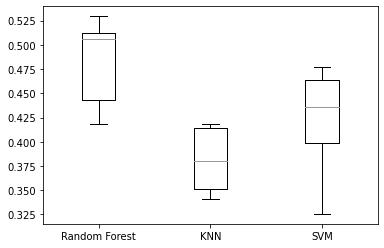

In [4]:
models = {'Random Forest': RandomForestClassifier(), 'KNN': KNeighborsClassifier(), 'SVM': SVC()}
results = []
for model in models.values():
    kf = KFold(n_splits = 6, random_state = 42, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf)
    results.append(cv_results)
    
plt.boxplot(results, labels = models.keys())
plt.show()

None of the models are looking very good based on accuracy, but it looks like RandomForest will end up being the best model. We will need to fine tune these options to see if they improve at all. 

**Class Weights**

In [5]:
class_weights = {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 20}

**Random Forest**

In [6]:
#RF is dependent on number of trees, going to try and optimize to keep from overfitting
est = np.arange(1,50)
train_acc_est = {}
test_acc_est = {}

for n in est:
    rf = RandomForestClassifier(n_estimators = n, class_weight = class_weights)
    rf.fit(X_train, y_train.values.ravel())
    train_acc_est[n] = rf.score(X_train, y_train)
    test_acc_est[n] = rf.score(X_test, y_test)

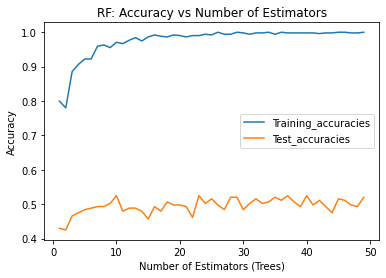

In [7]:
#Plotting the accuracies
plt.title('RF: Accuracy vs Number of Estimators')
plt.plot(est, train_acc_est.values(), label = 'Training_accuracies')
plt.plot(est, test_acc_est.values(), label = 'Test_accuracies')
plt.legend()
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy')
plt.show()

In [8]:
#RF is also dependent on max_depth, going to try and optimize to keep from overfitting
dep = np.arange(1,50)
train_acc_d = {}
test_acc_d = {}

for d in dep:
    rf = RandomForestClassifier(n_estimators = 30, max_depth = d, class_weight = class_weights)
    rf.fit(X_train, y_train.values.ravel())
    train_acc_d[d] = rf.score(X_train, y_train)
    test_acc_d[d] = rf.score(X_test, y_test)

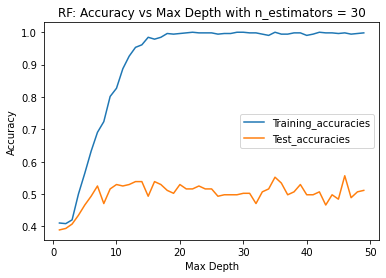

In [9]:
#Plotting the accuracies
plt.title('RF: Accuracy vs Max Depth with n_estimators = 30')
plt.plot(dep, train_acc_d.values(), label = 'Training_accuracies')
plt.plot(dep, test_acc_d.values(), label = 'Test_accuracies')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [10]:
#Looking at Accuracy for our final model with n_estimators = 30 and max_depth = 10
rf = RandomForestClassifier(n_estimators = 30, max_depth = 10, class_weight = 'balanced')
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)

train_acc_rf = rf.score(X_train, y_train)
test_acc_rf = rf.score(X_test, y_test)

print('Training accuracy:', train_acc_rf, '    Testing accuracy:', test_acc_rf)

Training accuracy: 0.867704280155642     Testing accuracy: 0.5520361990950227


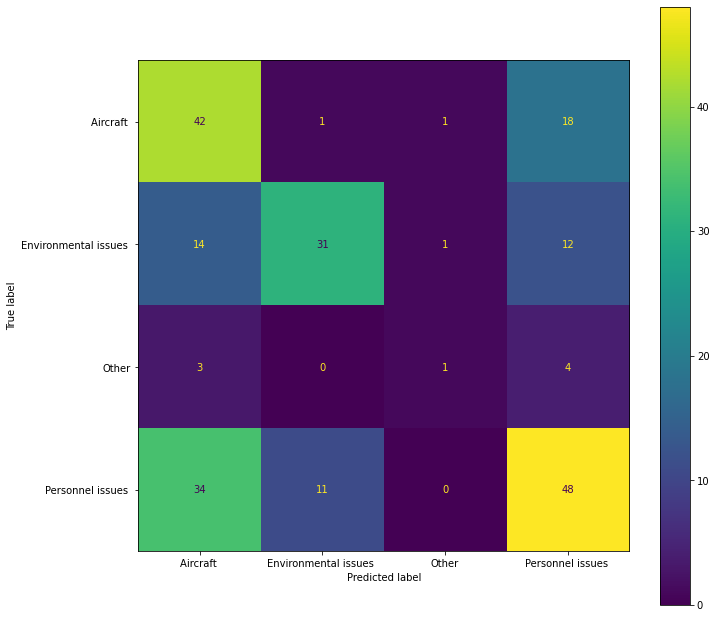

In [11]:
cf_matrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = rf.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [12]:
print(classification_report(y_test, y_pred, target_names = rf.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.45      0.68      0.54        62
Environmental issues        0.72      0.53      0.61        58
                Other       0.33      0.12      0.18         8
    Personnel issues        0.59      0.52      0.55        93

             accuracy                           0.55       221
            macro avg       0.52      0.46      0.47       221
         weighted avg       0.57      0.55      0.55       221



**K-Nearest Neighbor**

In [13]:
#KNN is dependent on how many neighbors you tell it to use. So going to look at that first
neighbors = np.arange(1,20)
train_acc = {}
test_acc = {}

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
    knn.fit(X_train, y_train.values.ravel())
    train_acc[n] = knn.score(X_train, y_train)
    test_acc[n] = knn.score(X_test, y_test)

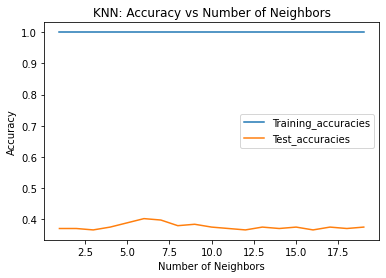

In [14]:
#Plotting the accuracies
plt.title('KNN: Accuracy vs Number of Neighbors')
plt.plot(neighbors, train_acc.values(), label = 'Training_accuracies')
plt.plot(neighbors, test_acc.values(), label = 'Test_accuracies')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [15]:
#Looking at Accuracy for our final model with n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knn.fit(X_train, y_train.values.ravel())
y_pred = knn.predict(X_test)

train_acc_knn = knn.score(X_train, y_train)
test_acc_knn = knn.score(X_test, y_test)

print('Training accuracy:', train_acc_knn, '    Testing accuracy:', test_acc_knn)

Training accuracy: 1.0     Testing accuracy: 0.3891402714932127


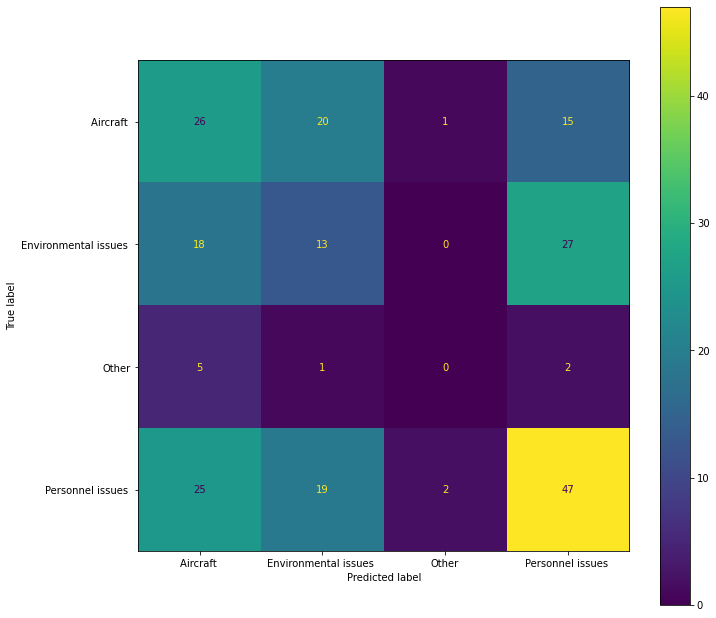

In [16]:
cf_matrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = knn.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [17]:
print(classification_report(y_test, y_pred, target_names = knn.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.35      0.42      0.38        62
Environmental issues        0.25      0.22      0.23        58
                Other       0.00      0.00      0.00         8
    Personnel issues        0.52      0.51      0.51        93

             accuracy                           0.39       221
            macro avg       0.28      0.29      0.28       221
         weighted avg       0.38      0.39      0.38       221



**Support Vector Machine**

In [18]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'class_weight': [{'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 1},
                             {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 5},
                             {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 10},
                             {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 5},
                             {'Aircraft ': 2, 'Environmental issues ': 2, 'Personnel issues ':1, 'Other': 10}]}
  
grid = GridSearchCV(SVC(), param_grid, refit = True)
  
# fitting the model for grid search
grid.fit(X_train, y_train.values.ravel())

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'class_weight': [{'Aircraft ': 1,
                                           'Environmental issues ': 1,
                                           'Other': 1, 'Personnel issues ': 1},
                                          {'Aircraft ': 1,
                                           'Environmental issues ': 1,
                                           'Other': 5, 'Personnel issues ': 1},
                                          {'Aircraft ': 1,
                                           'Environmental issues ': 1,
                                           'Other': 10,
                                           'Personnel issues ': 1},
                                          {'Aircraft ': 2,
                                           'Environmental issues ': 2,
                                           'Other': 5, 'Personnel issues ': 1},
                                          {'Aircraft ': 2,
                                           'Environmental issues ': 2,
                                           'Other': 10,
                                           'Personnel issues ': 1}],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]})

In [19]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'class_weight': {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ': 1, 'Other': 1}, 'gamma': 0.01}
SVC(C=1,
    class_weight={'Aircraft ': 1, 'Environmental issues ': 1, 'Other': 1,
                  'Personnel issues ': 1},
    gamma=0.01)


In [20]:
#Looking at Accuracy for our final model with C = 1 and gamma = 0.01
svm = SVC(C = 1, gamma = .01, class_weight = {'Aircraft ': 1, 'Environmental issues ': 1, 'Personnel issues ':1, 'Other': 1})
svm.fit(X_train, y_train.values.ravel())
y_pred = svm.predict(X_test)

train_acc_svm = svm.score(X_train, y_train)
test_acc_svm = svm.score(X_test, y_test)

print('Training accuracy:', train_acc_svm, '    Testing accuracy:', test_acc_svm)

Training accuracy: 0.9494163424124513     Testing accuracy: 0.4072398190045249


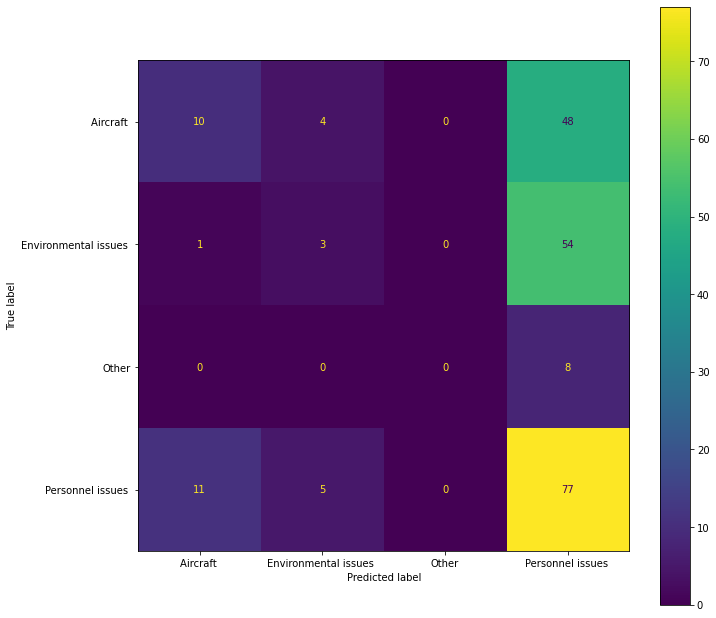

In [21]:
cf_matrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = svm.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [22]:
print(classification_report(y_test, y_pred, target_names = svm.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.45      0.16      0.24        62
Environmental issues        0.25      0.05      0.09        58
                Other       0.00      0.00      0.00         8
    Personnel issues        0.41      0.83      0.55        93

             accuracy                           0.41       221
            macro avg       0.28      0.26      0.22       221
         weighted avg       0.37      0.41      0.32       221



**Oversampling**

We've definitely have an imbalanced dataset, which class weights don't seem to help very much. So I'm going to try oversampling using SMOTE.

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Now going to try running the three models again with the oversampled data.

**Over Sampled Random Forest**

In [25]:
#RF is dependent on number of trees, going to try and optimize to keep from overfitting
est = np.arange(1,50)
rfs_train_acc_est = {}
rfs_test_acc_est = {}

for n in est:
    rf_s = RandomForestClassifier(n_estimators = n)
    rf_s.fit(X_train_smote, y_train_smote.values.ravel())
    rfs_train_acc_est[n] = rf_s.score(X_train_smote, y_train_smote)
    rfs_test_acc_est[n] = rf_s.score(X_test, y_test)

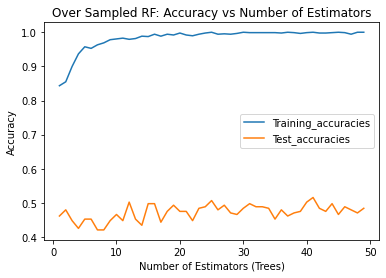

In [26]:
#Plotting the accuracies
plt.title('Over Sampled RF: Accuracy vs Number of Estimators')
plt.plot(est, rfs_train_acc_est.values(), label = 'Training_accuracies')
plt.plot(est, rfs_test_acc_est.values(), label = 'Test_accuracies')
plt.legend()
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy')
plt.show()

In [27]:
#RF is also dependent on max_depth, going to try and optimize to keep from overfitting
dep = np.arange(1,50)
rfs_train_acc_d = {}
rfs_test_acc_d = {}

for d in dep:
    rf_S = RandomForestClassifier(n_estimators = 30, max_depth = d)
    rf_s.fit(X_train_smote, y_train_smote.values.ravel())
    rfs_train_acc_d[d] = rf_s.score(X_train_smote, y_train_smote)
    rfs_test_acc_d[d] = rf_s.score(X_test, y_test)

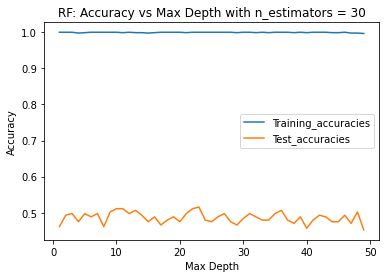

In [28]:
#Plotting the accuracies
plt.title('RF: Accuracy vs Max Depth with n_estimators = 30')
plt.plot(dep, rfs_train_acc_d.values(), label = 'Training_accuracies')
plt.plot(dep, rfs_test_acc_d.values(), label = 'Test_accuracies')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [29]:
#Looking at Accuracy for our final model with n_estimators = 30 and max_depth = 10
rf_s = RandomForestClassifier(n_estimators = 30, max_depth = 10)
rf_s.fit(X_train_smote, y_train_smote.values.ravel())
y_pred = rf_s.predict(X_test)

train_acc_rfs = rf_s.score(X_train_smote, y_train_smote)
test_acc_rfs = rf_s.score(X_test, y_test)

print('Training accuracy:', train_acc_rfs, '    Testing accuracy:', test_acc_rfs)

Training accuracy: 0.8882488479262672     Testing accuracy: 0.5067873303167421


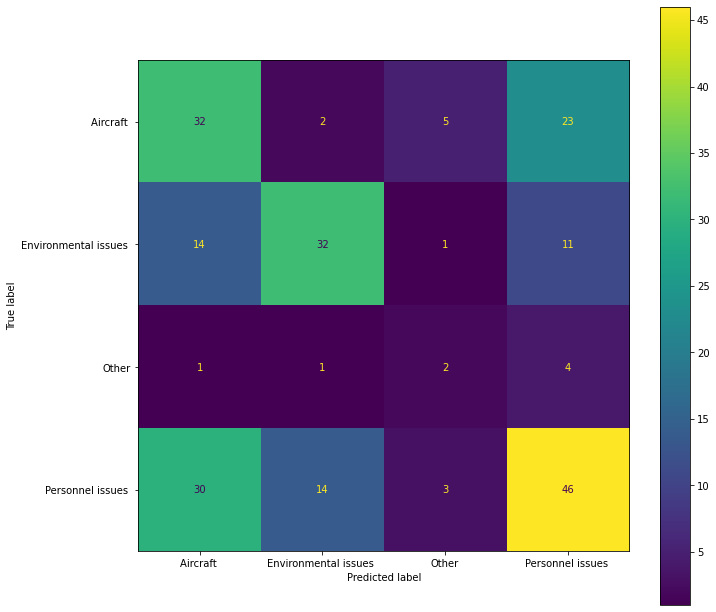

In [30]:
cf_matrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = rf_s.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [31]:
print(classification_report(y_test, y_pred, target_names = rf_s.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.42      0.52      0.46        62
Environmental issues        0.65      0.55      0.60        58
                Other       0.18      0.25      0.21         8
    Personnel issues        0.55      0.49      0.52        93

             accuracy                           0.51       221
            macro avg       0.45      0.45      0.45       221
         weighted avg       0.53      0.51      0.51       221



**Over Sampled K Nearest**

In [32]:
#Looking at Accuracy for our final model with n_neighbors = 5
knn_s = KNeighborsClassifier(n_neighbors = 5)
knn_s.fit(X_train_smote, y_train_smote.values.ravel())
y_pred = knn_s.predict(X_test)

train_acc_knns = knn_s.score(X_train_smote, y_train_smote)
test_acc_knns = knn_s.score(X_test, y_test)

print('Training accuracy:', train_acc_knns, '    Testing accuracy:', test_acc_knns)

Training accuracy: 0.5990783410138248     Testing accuracy: 0.29411764705882354


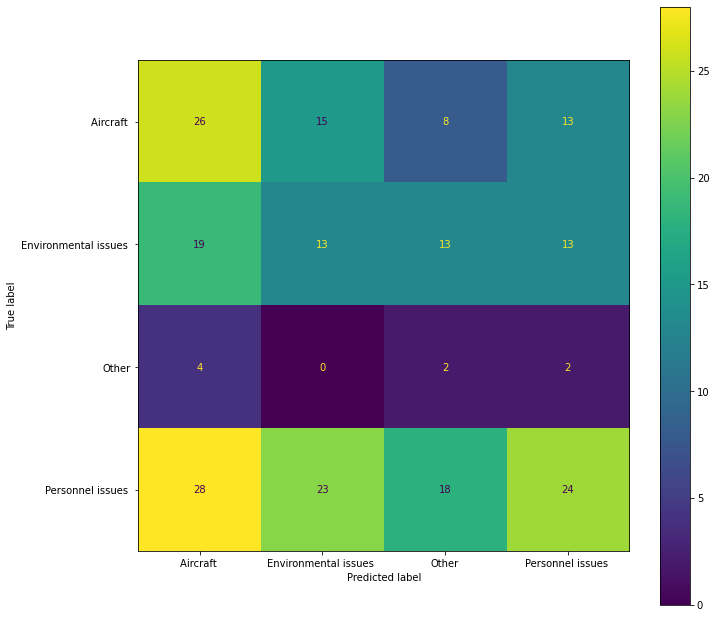

In [33]:
cf_matrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = knn_s.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [34]:
print(classification_report(y_test, y_pred, target_names = knn_s.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.34      0.42      0.37        62
Environmental issues        0.25      0.22      0.24        58
                Other       0.05      0.25      0.08         8
    Personnel issues        0.46      0.26      0.33        93

             accuracy                           0.29       221
            macro avg       0.28      0.29      0.26       221
         weighted avg       0.36      0.29      0.31       221



**Over Sampled SVM**

In [35]:
#Looking at Accuracy for our final model with C = 1 and gamma = 0.01
svm_s = SVC(C = 1, gamma = .01)
svm_s.fit(X_train_smote, y_train_smote.values.ravel())
y_pred = svm_s.predict(X_test)

train_acc_svms = svm_s.score(X_train_smote, y_train_smote)
test_acc_svms = svm_s.score(X_test, y_test)

print('Training accuracy:', train_acc_svms, '    Testing accuracy:', test_acc_svms)

Training accuracy: 0.9735023041474654     Testing accuracy: 0.3212669683257919


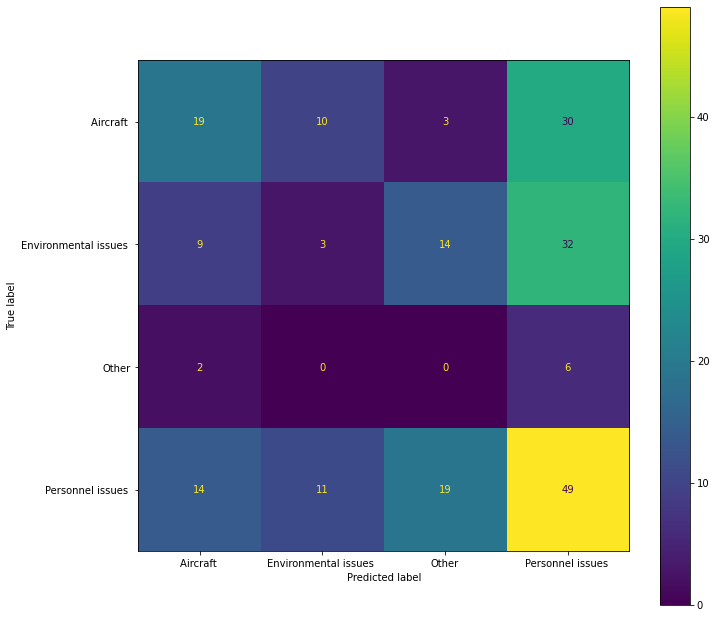

In [36]:
cf_matrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cf_matrix, display_labels = svm_s.classes_)

fig, ax = plt.subplots(figsize = (11,11))
cmd.plot(ax=ax)

In [37]:
print(classification_report(y_test, y_pred, target_names = svm_s.classes_, zero_division = 0))

                       precision    recall  f1-score   support

            Aircraft        0.43      0.31      0.36        62
Environmental issues        0.12      0.05      0.07        58
                Other       0.00      0.00      0.00         8
    Personnel issues        0.42      0.53      0.47        93

             accuracy                           0.32       221
            macro avg       0.24      0.22      0.22       221
         weighted avg       0.33      0.32      0.32       221

